In [31]:
import numpy as np 
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import matplotlib

import datetime
from tqdm import tqdm

from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.table import Table

from ResidualUtils import getwavs, getspecpath, getapstarpath, create_mask, get_selected_stars, get_residual, get_selected_stars



matplotlib.rcParams.update({'xtick.labelsize':18,
                            'ytick.labelsize':18,
                            'axes.titlesize':18,
                            'axes.labelsize':18,
                            'font.size':18,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif',
                            'text.usetex': False,
                            'pgf.texsystem': 'pdflatex'})
# plt.rcParams['pgf.texsystem'] = 'pdflatex'



flags = ['BADPIX',
'CRPIX',
'SATPIX',
'UNFIXABLE',
'BADDARK',
'BADFLAT',
'BADERR',
'NOSKY',
'LITTROW_GHOST',
'PERSIST_HIGH',
'PERSIST_MED',
'PERSIST_LOW',
'SIG_SKYLINE',
'SIG_TELLURIC']


from TolColors import tol_cmap
rainbow = tol_cmap('rainbow_PuRd')
sunset = tol_cmap('sunset')
iridescent = tol_cmap('iridescent')
for map in [rainbow, sunset, iridescent]:
    map.set_bad('white',1.)

In [20]:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)

CA_fields = ['CA_161-06_btx', 'CA_161-06_btx', 'CA_162-11_btx', 'CA_163-05_btx', 'CA_163-08_btx',
             'CA_165-07_btx', 'CA_165-10_btx']
CA_inds = np.unique(np.concatenate([np.where(stars['FIELD'] == field)[0] for field in CA_fields]))
CA_stars = stars[CA_inds]
CA_clean = CA_stars[np.invert(np.logical_or.reduce([np.isnan(CA_stars['TEFF']), np.isnan(CA_stars['LOGG']), 
                                           np.isnan(CA_stars['M_H'])]))]

select_bitmasked = np.where((np.bitwise_and(stars['ASPCAPFLAG'], 23) == 0) | 
                            (np.bitwise_and(stars['ASPCAPFLAG'], 19) == 0))[0] # perhaps I should also bitmask CA_clean

stars = stars[select_bitmasked]
stars = stars[np.where((stars['TEFF_ERR'] < 600) & (stars['LOGG_ERR'] < 0.5) & (stars['M_H_ERR'] < 0.3))[0]]
stars = stars[np.where(np.abs(stars['GLAT']) > 10)[0]]

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [21]:
meta = Table(fits.open('ResidualsFiles/meta_table.fits')[1].data)

def get_residual(teff, logg, m_h):
    rowselect = np.where(np.logical_and.reduce([teff >= meta['teff_low'], teff < meta['teff_high'], 
                    logg >= meta['logg_low'], logg < meta['logg_high'],
                   m_h >= meta['m_h_low'], m_h < meta['m_h_high']]))[0]
    if len(rowselect) != 1:
#         print('Wrong number of rows')
        return 
    
    row = meta[rowselect]
    j, k = (row['j_ind'], row['k_ind'])
    filename = row['fname'].item()
    hdulist = fits.open(filename)
    hdulist = np.array(hdulist)[1:].reshape(30,12)
    hdu = hdulist[j, k].item()
    return hdu

# uses previous function, just automated for a whole table
def get_residuals_from_tab(tab):
    residuals = []
    for row in tab:
        hdu = get_residual(row['TEFF'], row['LOGG'], row['M_H'])
        residuals.append(hdu)
    return residuals

In [7]:
teff_bins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
logg_bins = np.around(np.arange(-1, 5.2, 0.2), 2)
m_h_bins = np.around(np.concatenate([np.arange(-2.3, -1.1, 0.3), np.arange(-1.1, 0.5, 0.2), [0.5]]), 2)
print(len(teff_bins) - 1, len(logg_bins)-1, len(m_h_bins) - 1)

wavs = getwavs()

74 30 12


In [8]:
def grow_mask(masked_array, grow = 1):
    for i in range(grow):
        masktrue = np.where(masked_array.mask)[0]
        masktrue = np.setdiff1d(masktrue, [0, len(masked_array)-1])
        masked_array.mask[masktrue - 1] = True
        masked_array.mask[masktrue + 1] = True

In [9]:
n_select = 10
n_pix = 8575
threshold = 0.1

full_array = np.zeros((len(teff_bins)-1, len(logg_bins) - 1, len(m_h_bins) -1, len(wavs)))

for i in range(len(teff_bins)-1)[10:11]:
    for j in range(len(logg_bins)-1):
        for k in range(len(m_h_bins)-1):
            teff_bin = (teff_bins[i], teff_bins[i+1])
            logg_bin = (logg_bins[j], logg_bins[j+1])
            m_h_bin = (m_h_bins[k], m_h_bins[k+1])
            selected_stars = get_selected_stars(stars, teff_bin, logg_bin, m_h_bin)
            
            n = np.min([len(selected_stars), n_select]).astype(int)
            if n == 0:
                continue
                       
            selected_stars = selected_stars[np.random.choice(len(selected_stars), size = n)]
            
            data = np.zeros((n, n_pix))
            for rownum in range(n):
                row = selected_stars[rownum]
                aspcap = fits.open(getspecpath(row))[3].data
                if aspcap is None:
                    aspcap = np.empty(8575)
                    aspcap[:] = np.nan
                data[rownum, :] = aspcap
                
                
            row_median = np.nanmedian(data, axis = 1)
            mask = data < np.repeat(row_median, n_pix).reshape(n, n_pix) - threshold
            mask = np.sum(mask, axis = 0).astype(bool)
            full_array[i, j, k, :] = mask
            
            

[1. 1. 1. ... 1. 1. 1.]


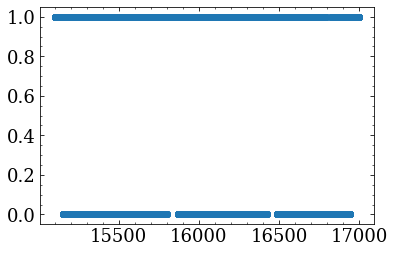

0.671137026239067


In [30]:

test = full_array[10,4,6]
print(test)
plt.scatter(wavs, test)
plt.show()

print(len(np.where(test == 0)[0])/len(wavs))



In [23]:
test_CA = CA_clean[0]
testres = get_residual(test_CA['TEFF'], test_CA['LOGG'], test_CA['M_H'])

NameError: name 'meta' is not defined

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


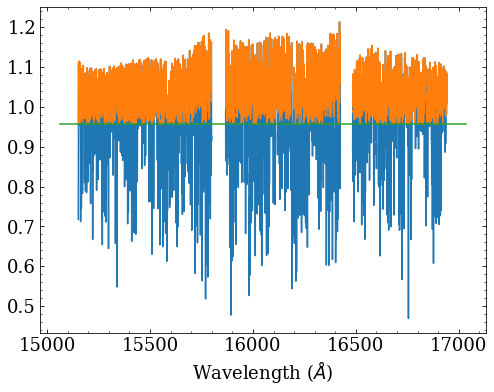

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


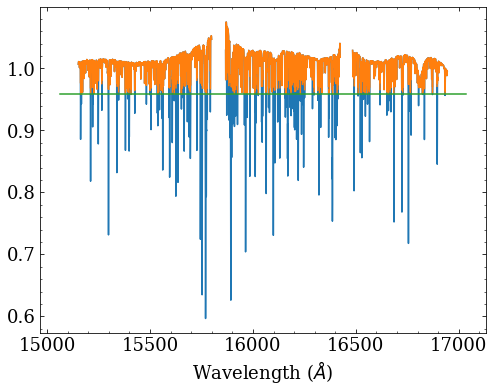

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


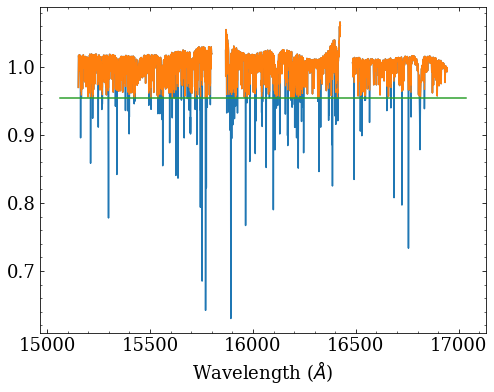

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


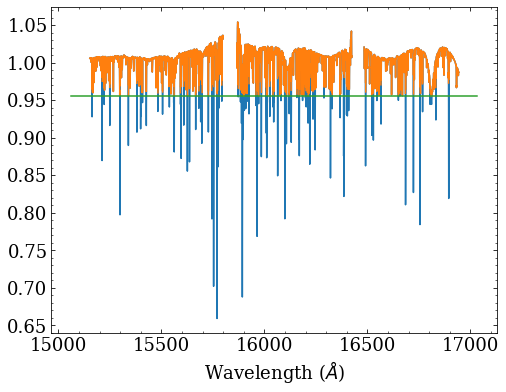

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


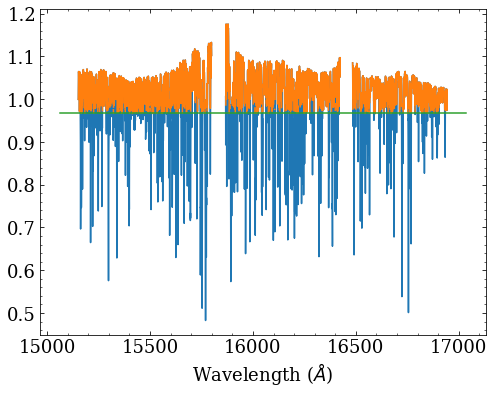

In [15]:
threshold = 0.05
wavs = getwavs()
for i in range(5):
    star_test = stars[i]
    aspcap_test = fits.open(getspecpath(star_test))[3].data
    aspcap_test = ma.array(aspcap_test, mask = aspcap_test == 0.0)
#     masked = sigma_clip(aspcap_test, sigma_upper = np.inf, sigma_lower = 3)

    absorption_lessthan = np.nanmedian(aspcap_test) - threshold
    masked = ma.array(aspcap_test, mask = aspcap_test < absorption_lessthan)
    
    fig, ax = plt.subplots(figsize = (8,6))
    
#     grow_mask(masked, 1)

    ax.plot(wavs, aspcap_test)
    ax.plot(wavs, masked)

#     ax.set_xlim(15200, 15300)
    ax.plot([*ax.get_xlim()], [absorption_lessthan, absorption_lessthan])


    ax.set_xlabel(r'Wavelength ($\AA$)')
    plt.show()

In [32]:
teff_bin = (teff_bins[i], teff_bins[i+1])
logg_bin = (logg_bins[j], logg_bins[j+1])
m_h_bin = (m_h_bins[k], m_h_bins[k+1])
selected_stars = get_selected_stars(stars, teff_bin, logg_bin, m_h_bin)

n = np.min([len(selected_stars), n_select]).astype(int)
if n == 0:
    continue

selected_stars = selected_stars[np.random.choice(len(selected_stars), size = n)]

data = np.zeros((n, n_pix))
for rownum in range(n):
    row = selected_stars[rownum]
    aspcap = fits.open(getspecpath(row))[3].data
    if aspcap is None:
        aspcap = np.empty(8575)
        aspcap[:] = np.nan
    data[rownum, :] = aspcap


row_median = np.nanmedian(data, axis = 1)
mask = data < np.repeat(row_median, n_pix).reshape(n, n_pix) - threshold
mask = np.sum(mask, axis = 0).astype(bool)
print(len(np.where(mask)[0]) / 8575)


SyntaxError: 'continue' not properly in loop (<ipython-input-32-15f6de325f3c>, line 8)